<a href="https://colab.research.google.com/github/karentp/ProbabilisticModelsProjects/blob/main/P4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

## Universidad de Costa Rica
### Escuela de Ingeniería Eléctrica
#### IE0405 - Modelos Probabilísticos de Señales y Sistemas

Segundo semestre del 2020

---

* Estudiante: **Katherine Chavarría Nájera**
* Carné: **B41841**
* Grupo: **1**

---
# `P4` - *Modulación digital IQ*
---

## - Solución de las asignaciones del proyecto

### 1. - Modulación QPSK

* (50%) Realice una simulación del sistema de comunicaciones como en la sección 3.2., pero utilizando una modulación QPSK en lugar de una modulación BPSK. Deben mostrarse las imágenes enviadas y recuperadas y las formas de onda.

### 1.1. Funciones implementadas:
A continuación se especificarán las funciones desarrolladas en la simulación del sistema, donde se utiliza Tx para referirse 
a transmisión y Rx a recepción.

#### 1.1.1. - Extracción de los pixeles de una imagen (fuente de información)

In [ ]:
# Se importa la librería "Image"
from PIL import Image

# Se importa la librería NumPy.
import numpy as np

# Se define la función "fuente_info"
def fuente_info(imagen):
    '''Una función que simula una fuente de
    información al importar una imagen y 
    retornar un vector de NumPy con las 
    dimensiones de la imagen, incluidos los
    canales RGB: alto x largo x 3 canales

    :param imagen: Una imagen en formato JPG
    :return: un vector de pixeles
    '''
    img = Image.open(imagen)
    
    return np.array(img)

#### 1.1.2. - Codificación de pixeles a una base binaria (bits)

In [ ]:
# Se importa la librería NumPy.
import numpy as np

# Se define la función "rgb_a_bit"
def rgb_a_bit(imagen):
    '''
    Convierte los pixeles de base 
    decimal (de 0 a 255) a binaria 
    (de 00000000 a 11111111).

    :param imagen: array de una imagen 
    :return: Un vector de (1 x k) bits 'int'
    '''
    # Obtener las dimensiones de la imagen
    x, y, z = imagen.shape
    
    # Número total de pixeles
    n_pixeles = x * y * z

    # Convertir la imagen a un vector unidimensional de n_pixeles
    pixeles = np.reshape(imagen, n_pixeles)

   # Convertir los canales a base 2
    bits = [format(pixel,'08b') for pixel in pixeles]
    bits_Rx = np.array(list(''.join(bits)))
    
    return bits_Rx.astype(int)

#### 1.1.3. - Esquema de modulación QPSK

In [ ]:
# Se importa la librería NumPy.
import numpy as np

# Se define la función "modulador_I"
def modulador_I(bits, fc, mpp):
    
    bits_recibidos = bits.reshape(len(bits)//2,2) 
    
    # 1. Parámetros de la 'señal' de información (bits)
    N = len(bits_recibidos) # Cantidad de bits

    # 2. Construyendo un periodo de la señal portadora en fase "I".
    Tc = 1 / fc  # Tiempo de un periodo de la portadora I.
    t_periodo_I = np.linspace(0, Tc, mpp)
    portadora_I = np.cos(2*np.pi*fc*t_periodo_I)

    # 3. Inicializar la señal modulada s(t)
    t_simulacion = np.linspace(0, N*Tc, N*mpp) 
    senal_I = np.zeros(t_simulacion.shape)
    moduladora_I = np.zeros(t_simulacion.shape)  # señal de información
 
    # 4. Asignar las formas de onda según los bits (BPSK)
    for i, bit in enumerate(bits_recibidos):
        if bits_recibidos[i,0] == 1:
            senal_I[i*mpp : (i+1)*mpp] = portadora_I
            moduladora_I[i*mpp : (i+1)*mpp] = 1
        else:
            senal_I[i*mpp : (i+1)*mpp] = portadora_I * -1
            moduladora_I[i*mpp : (i+1)*mpp] = 0
    
    return senal_I, portadora_I, moduladora_I, t_simulacion, Tc, N  

#------------------------------------------------------------------------------------------------

# Se define la función "modulador_Q"
def modulador_Q(bits, fc, mpp):
    
    bits_recibidos = bits.reshape(len(bits)//2,2)
    
    # 1. Parámetros de la 'señal' de información (bits)
    N = len(bits_recibidos) # Cantidad de bits

    # 2. Construyendo un periodo de la señal portadora "Q".
    Tc = 1 / fc  # Tiempo de un periodo de la portadora Q.
    t_periodo_Q = np.linspace(0, Tc, mpp)
    portadora_Q = np.sin(2*np.pi*fc*t_periodo_Q)

    # 3. Inicializar la señal modulada s(t)
    t_simulacion = np.linspace(0, N*Tc, N*mpp) 
    senal_Q = np.zeros(t_simulacion.shape)
    moduladora_Q = np.zeros(t_simulacion.shape)  # señal de información
 
    # 4. Asignar las formas de onda según los bits (BPSK)
    for i, bit in enumerate(bits_recibidos):
        if bits_recibidos[i,1] == 1:
            senal_Q[i*mpp : (i+1)*mpp] = portadora_Q
            moduladora_Q[i*mpp : (i+1)*mpp] = 1
        else:
            senal_Q[i*mpp : (i+1)*mpp] = portadora_Q * -1
            moduladora_Q[i*mpp : (i+1)*mpp] = 0


    
    return senal_Q, portadora_Q, moduladora_Q 

#------------------------------------------------------------------------------------------------

# Se define la función "senal_modulada"
def senal_modulada(senal_I, senal_Q, moduladora_I, moduladora_Q, t_simulacion, Tc, N):
    
    # Se realiza la suma de las señales provenientes de cada portadora. 
    senal_Tx = senal_I + senal_Q
    
    # Se realiza la suma de las moduladoras provenientes de cada portadora.
    moduladora = moduladora_I + moduladora_Q
    
    
    # Calcular la potencia promedio de la señal modulada
    Pm = (1 / (N*Tc)) * np.trapz(pow(senal_Tx, 2), t_simulacion)
    
    return senal_Tx, Pm, moduladora

#### 1.1.4. - Construcción de un canal con ruido AWGN

In [ ]:
# Se importa la librería NumPy.
import numpy as np

# Se define la función "canal_ruidoso"
def canal_ruidoso(senal_Tx, Pm, SNR):
    '''Un bloque que simula un medio de trans-
    misión no ideal (ruidoso) empleando ruido
    AWGN. Pide por parámetro un vector con la
    señal provieniente de un modulador y un
    valor en decibelios para la relación señal
    a ruido.

    :param senal_Tx: El vector del modulador
    :param Pm: Potencia de la señal modulada
    :param SNR: Relación señal-a-ruido en dB
    :return: La señal modulada al dejar el canal
    '''
    # Potencia del ruido generado por el canal
    Pn = Pm / pow(10, SNR/10)

    # Generando ruido auditivo blanco gaussiano
    ruido = np.random.normal(0, np.sqrt(Pn), senal_Tx.shape)

    # Señal distorsionada por el canal ruidoso
    senal_Rx = senal_Tx + ruido

    return senal_Rx

#### 1.1.5. - Esquema de demodulación

In [ ]:
# Se importa la librería NumPy.
import numpy as np

# Se define la función "demodulador"
def demodulador(senal_Rx, portadora_I, portadora_Q, mpp):
    '''Un método que simula un bloque demodulador
    de señales, bajo un esquema QPSK. El criterio
    de demodulación se basa en decodificación por 
    detección de energía.

    :param senal_Rx: La señal recibida del canal
    :param portadora_I: La onda portadora "en fase"
    :param portadora_Q: La onda portadora "en cuadratura"
    :param mpp: Número de muestras por periodo
    :return: Los bits de la señal demodulada
    '''
    # Cantidad de muestras en senal_Rx
    M = len(senal_Rx)

    # Cantidad de bits en transmisión
    N = int(M / mpp)

    # Vector para bits obtenidos por la demodulación
    bits_Rx_I = np.zeros(N)
    bits_Rx_Q = np.zeros(N)
    bits_Rx = np.zeros(2*N)

    # Vector para la señal demodulada
    senal_demodulada = np.zeros(M)

    # Pseudo-energía de un período de la portadora "I"
    Es_I = np.sum(portadora_I**2)
    
    # Pseudo-energía de un período de la portadora "Q"
    Es_Q = np.sum(portadora_Q**2)

    # Demodulación
    for i in range(N):
        # Producto interno de dos funciones
        producto_I = senal_Rx[i*mpp : (i+1)*mpp] * portadora_I
        producto_Q = senal_Rx[i*mpp : (i+1)*mpp] * portadora_Q
        Ep_I = np.sum(producto_I)
        Ep_Q = np.sum(producto_Q)
        senal_demodulada[i*mpp : (i+1)*mpp] = producto_I + producto_Q
         

        # Criterio de decisión por detección de energía
        if Ep_I > 0:
            bits_Rx_I[i] = 1
        else:
            bits_Rx_I[i] = 0
            
        if Ep_Q > 0:
            bits_Rx_Q[i] = 1
        else:
            bits_Rx_Q[i] = 0
            
    # Se vuelven a acomodar los bits en el orden apropiado.        
    for j, bits_I in enumerate(bits_Rx_I):
        bits_Rx[2*j] = bits_I 
        
    for k, bits_Q in enumerate(bits_Rx_Q):
        bits_Rx[2*k+1] = bits_Q

    return bits_Rx.astype(int), senal_demodulada

#### 1.1.6. - Reconstrucción de la imagen

In [ ]:
# Se importa la librería NumPy.
import numpy as np

# Se define la finción "bits_a_rgb"
def bits_a_rgb(bits_Rx, dimensiones):
    '''Un blque que decodifica el los bits
    recuperados en el proceso de demodulación

    :param: Un vector de bits 1 x k 
    :param dimensiones: Tupla con dimensiones de la img.
    :return: Un array con los pixeles reconstruidos
    '''
    # Cantidad de bits
    N = len(bits_Rx)

    # Se reconstruyen los canales RGB
    bits = np.split(bits_Rx, N / 8)

    # Se decofican los canales:
    canales = [int(''.join(map(str, canal)), 2) for canal in bits]
    pixeles = np.reshape(canales, dimensiones)

    return pixeles.astype(np.uint8)

### 1.2. - Simulación del sistema de comunicaciones con modulación QPSK

**Nota**: esta simulación tarda un poco.

Duración de la simulación:  5.728185653686523
0 errores, para un BER de 0.0000.


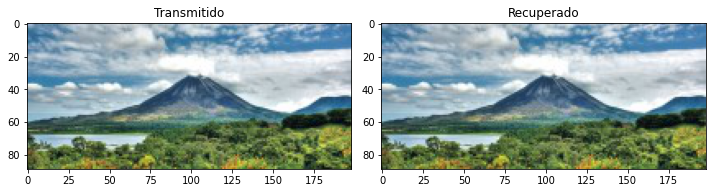

In [ ]:
# Se importa la librería NumPy.
import numpy as np

# Se importa la biblioteca "matplotlib" junto con la función "pyplot".
import matplotlib.pyplot as plt
import time

# Parámetros
fc = 5000  # frecuencia de ambas portadoras
mpp = 20   # muestras por periodo de la portadora
SNR = 5    # relación señal-a-ruido del canal

# Iniciar medición del tiempo de simulación
inicio = time.time()

# 1. Importar y convertir la imagen a trasmitir
imagen_Tx = fuente_info('arenal.jpg')
dimensiones = imagen_Tx.shape

# 2. Codificar los pixeles de la imagen
bits_Tx = rgb_a_bit(imagen_Tx)

# 3. Modular la cadena de bits usando el esquema QPSK
senal_I, portadora_I, moduladora_I, t_simulacion, Tc, N = modulador_I(bits_Tx, fc, mpp)

# 4. Modular la cadena de bits usando el esquema QPSK
senal_Q, portadora_Q, moduladora_Q = modulador_Q(bits_Tx, fc, mpp)

# 5. Modular la cadena de bits usando el esquema QPSK
senal_Tx, Pm, moduladora = senal_modulada(senal_I, senal_Q, moduladora_I, moduladora_Q, t_simulacion, Tc, N)

# 6. Se transmite la señal modulada, por un canal ruidoso
senal_Rx = canal_ruidoso(senal_Tx, Pm, SNR)

# 7. Se desmodula la señal recibida del canal
bits_Rx, senal_demodulada = demodulador(senal_Rx, portadora_I, portadora_Q, mpp)

# 8. Se visualiza la imagen recibida 
imagen_Rx = bits_a_rgb(bits_Rx, dimensiones)
Fig = plt.figure(figsize=(10,6))

# Cálculo del tiempo de simulación
print('Duración de la simulación: ', time.time() - inicio)

# 8. Calcular número de errores
errores = sum(abs(bits_Tx - bits_Rx))
BER = errores/len(bits_Tx)
print('{} errores, para un BER de {:0.4f}.'.format(errores, BER))

# Mostrar imagen transmitida
ax = Fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(imagen_Tx)
ax.set_title('Transmitido')

# Mostrar imagen recuperada
ax = Fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(imagen_Rx)
ax.set_title('Recuperado')
Fig.tight_layout()

plt.imshow(imagen_Rx)

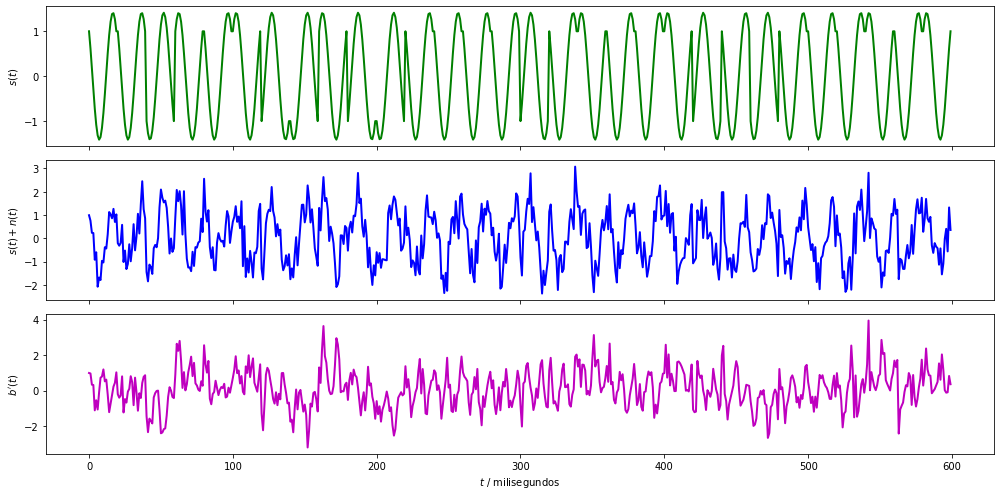

In [ ]:
# Se importa la biblioteca "matplotlib" junto con la función "pyplot".
import matplotlib.pyplot as plt

# Visualizar el cambio entre las señales
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(14, 7))

# La señal modulada por BPSK
ax1.plot(senal_Tx[0:600], color='g', lw=2) 
ax1.set_ylabel('$s(t)$')

# La señal modulada al dejar el canal
ax2.plot(senal_Rx[0:600], color='b', lw=2) 
ax2.set_ylabel('$s(t) + n(t)$')

# La señal demodulada
ax3.plot(senal_demodulada[0:600], color='m', lw=2) 
ax3.set_ylabel('$b^{\prime}(t)$')
ax3.set_xlabel('$t$ / milisegundos')
fig.tight_layout()
plt.show() # Muestra la gráfica.

### 2. - Estacionaridad y ergodicidad

* (30%) Realice pruebas de estacionaridad y ergodicidad a la señal modulada `senal_Tx` y obtenga conclusiones sobre estas.

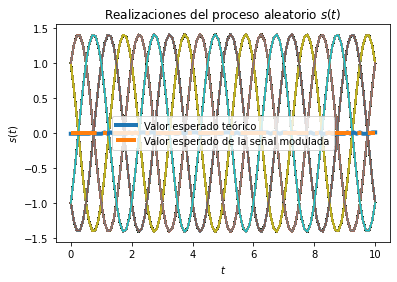

In [ ]:
# Se importa la librería NumPy.
import numpy as np

# Se importa el módulo stats de SciPy.
from scipy import stats

# Se importa la biblioteca "matplotlib" junto con la función "pyplot".
import matplotlib.pyplot as plt

# Parámetros
fc = 5000  # frecuencia de ambas portadoras
p = 1/2


# Variables aleatorias A1 y A2.
va_A1 = stats.bernoulli(p)
va_A2 = stats.bernoulli(p) 

# Creación del vector de tiempo
T = 100         # número de elementos
t_final = 10    # tiempo en segundos
t = np.linspace(0, t_final, T)

# N realizaciones
N = 10000

# Funciones del tiempo S(t) con N realizaciones
S_t = np.empty((N, len(t))) 

# Creación de las muestras del proceso s(t)
for i in range(N):
    A1 = va_A1.rvs()
    A2 = va_A2.rvs()
    
    if A1==0:
        A1=-1
    else:
        A1=1
    
    if A2==0:
        A2=-1
    else:
        A2=1
        
    s_t = A1 * np.cos(2*np.pi*fc*t) + A2 * np.sin(2*np.pi*fc*t)
    S_t[i,:] = s_t
        
    plt.plot(t, s_t)
    
# Promedio de s(t).
P = [np.mean(S_t[i,:]) for i in range(len(t))]
plt.plot(t, P, lw=4, label='Valor esperado teórico')
    
# Promedio se la senal_Tx.
P = [np.mean(senal_Tx) for i in range(len(t))]
plt.plot(t, P, '-.', lw=4, label='Valor esperado de la señal modulada')
    
# Mostrar las realizaciones, y su promedio calculado y teórico
plt.title('Realizaciones del proceso aleatorio $s(t)$')
plt.xlabel('$t$')
plt.ylabel('$s(t)$')
plt.legend() # Se imprime las leyendas de la gráfica.
plt.show()   # Muestra la gráfica.

'''
Cáculo de la autocorrelación 
'''

# T valores de desplazamiento tau
desplazamiento = np.arange(T)
taus = desplazamiento/t_final

# Inicialización de matriz de valores de correlación para las N funciones
corr = np.empty((N, len(desplazamiento)))

# Nueva figura para la autocorrelación
plt.figure()

# Cálculo de correlación para cada valor de tau
for n in range(N):
    for i, tau in enumerate(desplazamiento):
        corr[n, i] = np.correlate(senal_Tx, np.roll(senal_Tx, tau))/T
    plt.plot(taus, corr[n,:])

### 3. - Densidad espectral de potencia

* (20%) Determine y grafique la densidad espectral de potencia para la señal modulada `senal_Tx`.

In [ ]:
# Se importa la función fft de SciPy.
from scipy import fft

# Transformada de Fourier 
senal_f = fft(senal_Tx) # La función fft realiza el cálculo de la transformada rápida de Fourier de la senal_Tx. 

# Muestras de la señal
Nm = len(senal_Tx)

# Número de símbolos
Ns = Nm // mpp

# Tiempo del símbolo
Ts = 1 / fc

# Tiempo entre muestras (período de muestreo)
Tm = Ts / mpp

# Tiempo de la simulación
T = Ns * Ts

# Espacio de frecuencias
f = np.linspace(0.0, 1.0/(2.0*Tm), Nm//2)

# Se define la densidad espectral de potencia Sxx = |s(w)|^2
S_xx = np.power(np.abs(senal_f), 2)

# Se imprime la densidad espectral de potencia para la señal modulada.
print('----------\nDensidad espectral de potencia para la señal modulada\n----------')
print(S_xx)
print('----------\n')

# Se grafica la densidad espectral de potencia para la señal modulada con respecto a la frecuencia. 
plt.plot(f, 2.0/Nm * np.power(np.abs(senal_f[0:Nm//2]), 2), color = 'darkmagenta' , label='$S_{XX}(f)$')
plt.xlim(0, 20000)
plt.title('Densidad espectral de potencia para $s(t)$')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Densidad espectral de potencia')
plt.legend() # Se imprime la leyenda de la gráfica.
plt.grid()   
plt.show()   # Muestra la gráfica.

---

### Universidad de Costa Rica
#### Facultad de Ingeniería
##### Escuela de Ingeniería Eléctrica

---